<a href="https://colab.research.google.com/github/felipmorais/Affect_Dynamics_Automatic_Model_Building/blob/main/Affect_Dynamics_Automatic_Model_Building_General%2C_gender%2C_and_permanence_time_based_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Development of the affect dynamics model in the Brazilian context**
---


This code was developed to calculate the affect dynamics model. Unlike other open source code, this code is designed to:

1. Calculate the adjusted L metric;
2. Apply a t-test to calculate the statistical significance of the results considering all students;
3. Apply the p-value adjustment calculation for multiple tests, considering the Benjamini/Hochberg (BH) method;
4. Print calculated statistics in tabular form;
5. Automatically render affect dynamics graphical model based on calculated statistics, considering only transitions reported as significant after p-value adjustment based on BH method;
6. Calculate affect dynamics general model considering all the students;
7. Calculate models of affect dynamics considering the students' gender;
8. Develop the affect dynamics model according to the time spent in each emotion




---
**Important:** This code is part of a scientific article submitted for evaluation.
*Please do not share this code until the article is published.*

Execution 1: Lib imports and data files load
---
This code is used to import and pre-process the emotions file. It is important that this file is ordered according to the occurrence of emotions and the id of the respective student. It also loads the file with the emotions permanence time.


In [ ]:
# libs import and file loader
import numpy as np
import pandas as pd 
from scipy import stats
from scipy.stats import shapiro
import statsmodels.stats.multitest as multi
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
%matplotlib inline
import networkx as nx
import statistics

from google.colab import drive

drive.mount('/content/drive')

# file with all logs with emotion labels
# CSV Data example:
# student_id,emotion_label
# 1,ENGAGEMENT
# 1,ENGAGEMENT
# 1,CONFUSION
# 1,CONFUSION
# 1,CONFUSION
# 1,CONFUSION
# 1,CONFUSION
# 1,CONFUSION
# 1,BOREDOM
# 1,BOREDOM
# 1,BOREDOM
# 1,BOREDOM
# 1,BOREDOM
# 1,BOREDOM
# 1,FRUSTRATION
# 1,FRUSTRATION
# 1,FRUSTRATION
# 1,ENGAGEMENT
# 1,ENGAGEMENT
# 1,ENGAGEMENT
# 1,ENGAGEMENT
affect_labels_path = "/content/drive/MyDrive/<PATH_TO_THE_AFFECT_LABELS_FILE>.csv"
df_labels = pd.read_csv(affect_labels_path, delimiter=",")


# students information about gender
# CSV data example:
# student_id,gender
# 1,F
# 2,F
# 3,M
# 4,M
# 5,M
# 6,F
# 7,M
students_info_path = "/content/drive/MyDrive/<PATH_TO_THE_STUDENTS_INFO_FILE>.csv"
df_students_info = pd.read_csv(students_info_path, delimiter=",")

# file with the emotion duration (permanence time in each emotion) in seconds of the students
# CSV data example:
# student_id,emotion_label,duration
# 1,ENGAGEMENT,12
# 1,OTHER,2
# 1,ENGAGEMENT,19
# 1,OTHER,2
# 1,ENGAGEMENT,12
# 1,FRUSTRATION,2
# 1,ENGAGEMENT,4
# 1,CONFUSION,2
# 1,ENGAGEMENT,34
# 1,OTHER,15
# 1,ENGAGEMENT,13
# 1,CONFUSION,17
# 1,FRUSTRATION,3
emotions_duration_path = "/content/drive/MyDrive/<PATH_TO_THE_EMOTIONS_DURAION_FILE>.csv"
df_emotions_duration = pd.read_csv(emotions_duration_path, delimiter=",")

# data preparation for the log files
df_labels.loc[df_labels.emotion_label == "FRUSTRATION", "emotion_label"] = "FRU"
df_labels.loc[df_labels.emotion_label == "ENGAGEMENT", "emotion_label"] = "ENG"
df_labels.loc[df_labels.emotion_label == "CONFUSION", "emotion_label"] = "CON"
df_labels.loc[df_labels.emotion_label == "BOREDOM", "emotion_label"] = "BOR"
df_labels.loc[df_labels.emotion_label == "OTHER", "emotion_label"] = "OTH"
# remove na lines from the null emotion labels 
df_labels = df_labels[df_labels.emotion_label.notna()]


# data preparation for the emotion duration file
df_emotions_duration.loc[df_emotions_duration.emotion_label == "FRUSTRATION", "emotion_label"] = "FRU"
df_emotions_duration.loc[df_emotions_duration.emotion_label == "ENGAGEMENT", "emotion_label"] = "ENG"
df_emotions_duration.loc[df_emotions_duration.emotion_label == "CONFUSION", "emotion_label"] = "CON"
df_emotions_duration.loc[df_emotions_duration.emotion_label == "BOREDOM", "emotion_label"] = "BOR"
df_emotions_duration.loc[df_emotions_duration.emotion_label == "OTHER", "emotion_label"] = "OTH"
# remove na lines from the null emotion labels 
df_emotions_duration = df_emotions_duration[df_emotions_duration.emotion_label.notna()]

# define which emotions will be considered and in which order
emotions_list = ['ENG', 'CON', 'FRU', 'BOR', 'OTH']

# define the metrics that will be visible when the resulting table is printed
table_metrics_to_print = ['L_metric','p_value','transition_count','multiple_test_significance']

# define the at chance level when the emotions' co-occurence is removed from the data
# this value was defined according to the paper "A Re-Analysis and Synthesis of Data on Affect Dynamics in Learning", by Shamya Karumbaiah, Ryan Baker, Jaclyn Ocumpaugh, and Alexandra Andres
# it follows the formula: 1 / (n - 1)^2, in which n is the number of considered emotions. In this case, we have considered 5 emotions: 'ENG', 'CON', 'FRU', 'BOR', 'OTH'
L_metric_at_chance_threshold=0.0625

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Execution 2: L metric calculation methods
---
This first code is imported from the article "Adjusting the L Statistic when Self-Transitions are Excluded in Affect Dynamics", by authors Jeffrey Matayoshi and Shamya Karumbaiah, 2020.

The code has been kept completely for simplicity. Howeber, we have changed some methods in order to deal with the additional information about permanence time and to bring the list of all L-values to the t-test application, for the p-value calculation.

In [ ]:
# code from https://github.com/jmatayoshi/affect-transitions

import numpy as np

def remove_self_transitions(seq):
    return [st for i, st in enumerate(seq) if i == 0 or st != seq[i - 1]]


def generate_sequence(seq_length, state_dict, base_rates,
                      include_self_transitions=True):
    state_ind = np.arange(len(state_dict))
    if include_self_transitions:
        seq = list(
            np.random.choice(
                list(state_dict.values()),
                size=seq_length,
                p=base_rates
            )
        )
    else:
        base_rates = np.array(base_rates)
        # Construct mapping from each state to its index in state_dict
        inv_state_dict = {}
        for i in range(len(state_dict)):
            inv_state_dict[state_dict[i]] = i
        # Sample first state
        seq = [state_dict[np.random.multinomial(1, base_rates).argmax()]] 
        for i in range(seq_length - 1):
            # Get index of previous state
            prev_ind = inv_state_dict[seq[-1]]
            # Get indices of possible next states
            next_ind = np.setdiff1d(state_ind, [prev_ind])
            # Construct conditional rates of next states
            cond_next_rates = base_rates[next_ind] / (1 - base_rates[prev_ind])
            # Sample next state
            # np.random.multinomial is faster here than np.random.choice
            seq.append(state_dict[next_ind[
                np.random.multinomial(1, cond_next_rates).argmax()]])
    return seq


def get_counts(seq, states):
    next_count = {a: 0 for a in states}
    cond_count = {a: {b: 0 for b in states} for a in states}
    num_tr = len(seq) - 1
    # Compute next and conditional counts
    for i in np.arange(1, len(seq)):
        for a in states:
            if seq[i - 1] == a:
                for b in states:
                    if seq[i] == b:
                        cond_count[a][b] += 1
                        next_count[b] += 1
                        break
                break

    cond_count_list = []
    for a in cond_count:
        cond_count_list.extend(list(cond_count[a].values()))

    return list(next_count.values()), cond_count_list

def get_timed_counts(original_seq, timed_seq, states):
    next_count = {a: 0 for a in states}
    cond_count = {a: {b: 0 for b in states} for a in states}
    # num_tr = len(original_seq) - 1
    # Compute next counts
    for i in np.arange(1, len(original_seq)):
        for a in states:
            if original_seq[i - 1] == a:
                for b in states:
                    if original_seq[i] == b:
                        next_count[b] += 1
                        break
                break

    # Compute conditional counts
    for i in np.arange(1, len(timed_seq)):
        for a in states:
            if timed_seq[i - 1] == a:
                for b in states:
                    if timed_seq[i] == b:
                        cond_count[a][b] += 1
                        break
                break

    cond_count_list = []
    for a in cond_count:
        cond_count_list.extend(list(cond_count[a].values()))

    return list(next_count.values()), cond_count_list


def get_L_star_vals(a, b, next_counts, cond_counts, use_mean_rates=True):
    num_states = next_counts.shape[1]
    # Column indices where next != a (i.e., transitions in T_{A_complement})
    a_comp_ind = (
        np.array([i for i in range(num_states) if i != a])
    )
    # Count transitions where prev == a and next != a
    a_comp_cond_sum = cond_counts[:, a_comp_ind + a*num_states].sum(axis=1)
    if use_mean_rates:      
        # Compute L_star using base rates averaged over the whole sample
        # of sequences; note that as opposed to the computation of
        # L_star below, we only exclude samples with P(b|a) == nan; that is,
        # we only exclude sequences with no transitions from a to another state
        sample_pos = np.flatnonzero(
            a_comp_cond_sum > 0
        )
        # Compute mean base rate of b restricted to transitions with next != a
        modified_mean_base_rate = np.mean(
            next_counts[sample_pos, b] /
            next_counts[sample_pos, :][:, a_comp_ind].sum(axis=1)
        )
        # Compute conditional rate of b restricted to transitions with next != a
        cond_rates = (
            cond_counts[sample_pos, a*num_states + b] /
            a_comp_cond_sum[sample_pos]
        )
        L_star_vals = (
            (cond_rates - modified_mean_base_rate)
            / (1 - modified_mean_base_rate)
        )
    else:
        # Compute L_star using base rates from each individual sequence

        # Column indices where next != a and next != b
        a_b_comp_ind = (
            np.array([i for i in range(num_states) if i != a and i != b])
        )
        # Count transitions where next != a or next != b
        a_b_comp_sum = next_counts[:, a_b_comp_ind].sum(axis=1)
        # Count transitions where next != a        
        a_comp_sum = next_counts[:, b] + a_b_comp_sum
        # Find samples where:
        #  (a) P(b|a) != nan
        #  (b) P(b) < 1
        sample_pos = np.flatnonzero(
            (a_comp_cond_sum > 0) & (a_b_comp_sum > 0)            
        )        
        # Compute base rates of b restricted to transitions with next != a
        modified_base = (
            next_counts[sample_pos, b] / a_comp_sum[sample_pos]
        )
        # Compute conditional rate of b restricted to transitions with next != a
        cond_rates = (
            cond_counts[sample_pos, a*num_states + b] /
            a_comp_cond_sum[sample_pos]
        )       
        L_star_vals = (
            (cond_rates - modified_base)
            / (1 - modified_base)
        )
    return L_star_vals

def get_L_vals(a, b, next_counts, cond_counts, use_mean_rates=True):
    num_states = next_counts.shape[1]
    # Count transitions where prev == a and next != a
    a_cond_sum = cond_counts[
        :, np.arange(num_states) + a*num_states].sum(axis=1)
    if use_mean_rates:      
        # Compute L using base rates averaged over the whole sample
        # of sequences.  Note that as opposed to the computation of
        # L below, we only exclude samples with P(b|a) == nan; that is,
        # we only exclude sequences with no transitions from a 
        sample_pos = np.flatnonzero(
            a_cond_sum > 0
        )
        # Compute mean base rate of b 
        mean_base_rate = np.mean(
            next_counts[sample_pos, b] /
            next_counts[sample_pos, :].sum(axis=1)
        )
        # Compute conditional rate of b 
        cond_rates = (
            cond_counts[sample_pos, a*num_states + b] /
            a_cond_sum[sample_pos]
        )
        L_vals = (
            (cond_rates - mean_base_rate)
            / (1 - mean_base_rate)
        )
    else:
        # Compute L using base rates from each individual sequence

        # Column indices where next != a and next != b
        b_comp_ind = (
            np.array([i for i in range(num_states) if i != b])
        )
        # Count transitions where next != b
        b_comp_sum = next_counts[:, b_comp_ind].sum(axis=1)
        # Find samples where:
        #  (a) P(b|a) != nan
        #  (b) P(b) < 1
        sample_pos = np.flatnonzero(
            (a_cond_sum > 0) & (b_comp_sum > 0)            
        )        
        # Compute base rates of b
        base_rates = (
            next_counts[sample_pos, b] / next_counts[sample_pos, :].sum(axis=1)
        )
        # Compute conditional rate of b
        cond_rates = (
            cond_counts[sample_pos, a*num_states + b] /
            a_cond_sum[sample_pos]
        )       
        L_vals = (
            (cond_rates - base_rates)
            / (1 - base_rates)
        )
    return L_vals


def compile_timed_sequence_counts(seq_list, timed_seq_list, states):
    next_counts = []
    cond_counts = []    
    for seq_index in range(len(seq_list)):
        # count_res = get_counts(seq, states)
        count_res = get_timed_counts(seq_list[seq_index], timed_seq_list[seq_index], states)
        next_counts.append(count_res[0])
        cond_counts.append(count_res[1])
    return np.array(next_counts), np.array(cond_counts)


def compile_sequence_counts(seq_list, states):
    next_counts = []
    cond_counts = []    
    for seq_index in range(len(seq_list)):
        count_res = get_counts(seq_list[seq_index], states)
        next_counts.append(count_res[0])
        cond_counts.append(count_res[1])
    return np.array(next_counts), np.array(cond_counts)
    

def print_vals(val_array, state_dict, title):
    print('\n\n' + title + '\n')
    print('Prev\\Next' + '\t' + '\t'.join(map(str, list(state_dict.values()))))
    for i in range(len(state_dict)):
        print(state_dict[i] + '\t\t'
              + '\t'.join(map(str, val_array[i, :].round(4))))
    return


def run_simulations(
        num_trials=50000,
        seq_length=21,
        states=['A', 'B', 'C', 'D'],
        base_rates=np.array([0.45, 0.45, 0.05, 0.05]),
        verbose=True,
        include_self_transitions=True,
        compute_L=True
):
    num_states = len(states)
    state_dict = {}
    for i in range(num_states):
        state_dict[i] = states[i]
    seq_list = []
    reduced_seq_list = []
    for i in range(num_trials):
        seq = generate_sequence(seq_length, state_dict, base_rates,
                    include_self_transitions=include_self_transitions)        
        reduced_seq = remove_self_transitions(seq)

        seq_list.append(seq)
        reduced_seq_list.append(reduced_seq)

    res = []
    # Compute L_star using individual base rates from full sequences with
    # self-transitions included     
    res.append(
        compute_statistic(seq_list, states, L_star=True,
                          use_mean_rates=False)
    )
    # Compute L_star using mean base rates from full sequences with
    # self-transitions included         
    res.append(
        compute_statistic(seq_list, states, L_star=True,
                          use_mean_rates=True)
    )
    if compute_L:
        # Compute L using individual base rates from reduced sequences with
        # self-transitions removed             
        res.append(
            compute_statistic(seq_list, states, L_star=False,
                              use_mean_rates=False)
        )
        # Compute L_star using mean base rates from full sequences with
        # self-transitions included                  
        res.append(
            compute_statistic(seq_list, states, L_star=False,
                              use_mean_rates=True)
        )            

    
    if verbose:
        title_list = [
            'L_star with individual base rates from full sequences',
            'L_star with mean base rates from full sequences',
            'L with individual base rates from reduced sequences',
            'L with mean base rates from reduced sequences',
        ]
        end_ind = 2
        if compute_L:
            end_ind = len(title_list)
        for i in range(end_ind):
            print_vals(res[i], state_dict, title_list[i])
            
    return (
        seq_list,
        reduced_seq_list,
        res
    )


def compute_statistic(seq_list, states, L_star=True,
                      use_mean_rates=True, consider_timed_list=False, seq_timed_list=[]):
    """ General function for computing L_star and L statistics

    Parameters
    ----------
    seq_list : list of lists
        Each entry in the list is a sequence (list) of affective states; note 
        that self-transitions are automatically removed if L_star is false
        Example:
            [
                ['A', 'C', 'C', 'B', 'C'],
                ['B', 'C', 'A', 'C'],
                ['C', 'C', 'C', 'B', 'B', 'A']
            ]
    states : list 
        List containing all possible affective states 
        Example:
            ['A', 'B', 'C']
    L_star : bool, default=True 
        If true compute L_star statistic; otherwise, remove 
        self-transitions and compute L statistic
    use_mean_rates : bool, default=True
        If true compute base rates averaged over all sequences; otherwise,
       compute base rates individually per sequence
    """
    if L_star:
        input_list = seq_list
        if consider_timed_list:
          input_timed_list = seq_timed_list
    else:
        input_list = []
        if consider_timed_list:
          input_timed_list = []
        for i in range(len(seq_list)):
            input_list.append(remove_self_transitions(seq_list[i]))
            if consider_timed_list:
              input_timed_list.append(remove_self_transitions(seq_timed_list[i]))
    
    if consider_timed_list:
      next_counts, cond_counts = compile_timed_sequence_counts(input_list, input_timed_list, states)
    else:
      next_counts, cond_counts = compile_sequence_counts(input_list, states)

    num_states = len(states)
    res = np.full((num_states, num_states), np.nan)
    test = np.full((num_states, num_states), object)
    for i in range(num_states):
        for j in range(num_states):
            if i != j:
                if L_star:
                    aux = get_L_star_vals(i, j, next_counts, cond_counts, use_mean_rates=use_mean_rates)

                    res[i, j] = np.mean(aux)
                    test[i, j] = aux
                else:
                    aux = get_L_vals(i, j, next_counts, cond_counts, use_mean_rates=use_mean_rates)
                    
                    res[i, j] = np.mean(aux)
                    test[i, j] = aux

    return res, test


def base_rate_analysis(
        states=['A', 'B', 'C', 'D'],
        base_rates=np.ones(4)*0.25,
        num_steps=24,
        rate_step=[0.03, -0.01, -0.01, -0.01],
        num_trials=50000,
        seq_length=21
):
    """ Run numerical experiments 
    
    Experiment 1 parameters: 
        states=['A', 'B', 'C', 'D'], 
        base_rates=np.ones(4)*0.25, 
        num_steps=24, 
        rate_step=[0.03, -0.01, -0.01, -0.01],
        num_trials=50000,
        seq_length=21

    Experiment 2 parameters: 
        states=['A', 'B', 'C', 'D'], 
        base_rates=np.ones(4)*0.25, 
        num_steps=23, 
        rate_step=[0.01, 0.01, -0.01, -0.01],
        num_trials=50000,
        seq_length=21
    
    """
    rate_step = np.array(rate_step)
    indiv_rate_results = []
    mean_rate_results = []
    all_base_rates = []
    for i in range(num_steps):
        sim_res = run_simulations(
            num_trials=num_trials,
            seq_length=seq_length,
            states=states,
            base_rates=base_rates,
            verbose=False,
            include_self_transitions=True,
            compute_L=False
        )
        indiv_rate_results.append(sim_res[2][0])
        mean_rate_results.append(sim_res[2][1])
        all_base_rates.append(list(base_rates))
        if i < num_steps - 1:
            base_rates += rate_step
    return indiv_rate_results, mean_rate_results, all_base_rates



Execution 3: Definition of the functions and statistical calculations
---
This part of the code is the definition of the auxiliary functions for the calculation of the L metric, the p-value statistics and multiple tests and for the printing part of the results and the affect dynamics graph.


In [ ]:
# Function that computes the list of students that should be included in the analysis of the dynamics of emotions
# Returns a list with the ids of the students that will be included
# Output example: [1, 2, 3, 4, 5]

# students_amount -> the number of students that should be considered
#   by default this value is 30, but any value can be passed by parameter

# gender_filter -> specify whether the students should be filtered according their gender
#   by default this value is False

# gender_text -> specify which gender "M" or "F" should be used to filter students
#   by default this value is "M"

# show_info -> receives a boolean that informs if it is to display the information of the selected students
#   by default this value is True

def compute_students_to_include(students_amount=30,
                                gender_filter=False,
                                gender_text="M",
                                show_info=True):

  students_to_include = []
  for n_student in range(1, students_amount + 1, 1):
    include_n_student = False
    
    # condition to include or not students according their gender
    if gender_filter:
      if df_students_info[df_students_info.student_id == n_student].gender.values[0] == gender_text:
        include_n_student = True
      else: 
        include_n_student = False

    if not gender_filter:
      include_n_student = True

    if include_n_student:
      students_to_include.append(n_student)

  if show_info:
    print("Number of students: ", len(students_to_include))
    print("Students ids: ", students_to_include)
  
  return students_to_include


# receives a list of students ids to be considered and filter the emotion labels based on this list 
# and filters that can be modified according to the following paramenters

# students_to_include -> a list of students id to be considered
#   by default this value is []

# consider_emotion_duration -> a boolean to define whether the emotion labels dataset with permanence time should be considered
#   by default this value is False

# consider_emotion_duration -> a boolean to define whether the emotion labels should be filtered by the permanence time
#   by default this value is False

# emotion_to_filter_text -> the emotion that will be used to filter as the source emotion
#   by default this value is "ENG"

# duration_greater_than -> a boolean to define whether the permanence time in the emotion_to_filter_text should be greater or less then a certain threshold
#   by default this value is True

# duration_threshold_method -> defines the method to calculate the emotion duration threshold
#   by default this value is "mean"

# show_info -> receives a boolean that informs if it is to display the information of the selected students
#   by default this value is True
def compute_list_of_emotion_labels(students_to_include=[],
                                   consider_emotion_duration=False,
                                   filter_emotion_duration=False,
                                   emotion_to_filter_text="ENG",
                                   duration_greater_than=True,
                                   duration_threshold_method="mean",
                                   show_info=True):

  # it computes the emotion sequences for each student
  transitions_list = []
  duration_threshold = calculate_emotion_duration_stats(emotion_to_filter_text)[duration_threshold_method]
  for n_student in students_to_include:
    if consider_emotion_duration:
      emotions_duration_labels = df_emotions_duration[df_emotions_duration.student_id == n_student]
      if filter_emotion_duration:
        if duration_greater_than:
          emotions_duration_labels = emotions_duration_labels[((emotions_duration_labels.emotion_label == emotion_to_filter_text) & (emotions_duration_labels.duration >= duration_threshold) | (emotions_duration_labels.emotion_label != emotion_to_filter_text))]
        else:
          emotions_duration_labels = emotions_duration_labels[((emotions_duration_labels.emotion_label == emotion_to_filter_text) & (emotions_duration_labels.duration <= duration_threshold) | (emotions_duration_labels.emotion_label != emotion_to_filter_text))]

      transitions_list.append(list(emotions_duration_labels.emotion_label.values))
    else:
      transitions_list.append(list(df_labels[df_labels.student_id == n_student].emotion_label.values))

  if show_info:
    print("Affective states: ", emotions_list)
    print("Number of transition lists: ", len(transitions_list))
    print("Labels for each list:")
    for i in range(len(transitions_list)):
      print(str(students_to_include[i]) + ": " + str(len(transitions_list[i])))
    if consider_emotion_duration and filter_emotion_duration:
      if duration_greater_than:
        print("Number of resulting transitions: ", len(df_emotions_duration[(df_emotions_duration.emotion_label == emotion_to_filter_text) & (df_emotions_duration.duration >= duration_threshold)]))
      else: 
        print("Number of resulting transitions: ", len(df_emotions_duration[(df_emotions_duration.emotion_label == emotion_to_filter_text) & (df_emotions_duration.duration <= duration_threshold)]))

  return transitions_list


# compute the number of transitions between all the states and students
def get_emotion_transitions_counts(list_seq, states):
  cond_count = {a: {b: 0 for b in states} for a in states}
  for j in np.arange(0, len(list_seq)):
    seq = list_seq[j]
    num_tr = len(seq) - 1
    # Compute next and conditional counts
    for i in np.arange(1, len(seq)):
      for a in states:
        if seq[i - 1] == a:
          for b in states:
            if seq[i] == b:
              cond_count[a][b] += 1
              break
          break

  return cond_count


# compute and return the statistics about the permanence time of an emotion entered as text
def calculate_emotion_duration_stats(emotion_text):
  emotion_duration_stats = {}
  emotion_duration_stats["min"] = df_emotions_duration.loc[df_emotions_duration.emotion_label == emotion_text].duration.min()
  emotion_duration_stats["max"] = df_emotions_duration.loc[df_emotions_duration.emotion_label == emotion_text].duration.max()
  emotion_duration_stats["mean"] = df_emotions_duration.loc[df_emotions_duration.emotion_label == emotion_text].duration.mean()
  emotion_duration_stats["median"] = df_emotions_duration.loc[df_emotions_duration.emotion_label == emotion_text].duration.median()
  emotion_duration_stats["std"] = df_emotions_duration.loc[df_emotions_duration.emotion_label == emotion_text].duration.std()
  emotion_duration_stats["shapiro"], emotion_duration_stats["shapiro_p_value"] = shapiro(df_emotions_duration.loc[df_emotions_duration.emotion_label == emotion_text].duration)
  return emotion_duration_stats

# print the statistics of an emotion entered as text
def print_emotion_duration_stats(emotion_text):
  emotion_duration_stats = calculate_emotion_duration_stats(emotion_text)
  print("-------------- Emotion ", emotion_text, " ----------------------------")
  print("Min: ", emotion_duration_stats["min"])
  print("Max: ", emotion_duration_stats["max"])
  print("Mean: ", emotion_duration_stats["mean"])
  print("Median: ", emotion_duration_stats["median"])
  print("Std. Dev.: ", emotion_duration_stats["std"])
  print('Shapiro-Wilk=%.3f, p=%.3f' % (emotion_duration_stats["shapiro"], emotion_duration_stats["shapiro_p_value"]))

# receives a matrix with the L metric average for each emotion transition combination and calculates the p-value for each combination
def calculate_p_values(states_list, L_metric_average_results, level_at_change):
  num_states = len(states_list)
  matrix_p_values = np.full((num_states, num_states), np.nan)
  for i in range(num_states):
    for j in range(num_states):
      if i != j:
        matrix_p_values[i][j] = stats.ttest_1samp(list(L_metric_average_results[i][j]), level_at_change).pvalue
  return matrix_p_values

# calculate Benjamini/Hochberg multiple test adjustment for the p-values matrix
# https://www.statsmodels.org/dev/generated/statsmodels.stats.multitest.multipletests.html
def calculate_multiple_t_test_adjustment(states_list, matrix_p_values):
  num_states = len(states_list)
  multiple_tests_matrix = np.full((num_states ,num_states), np.nan)
  multiple_tests_reject_matrix = np.full((num_states ,num_states), np.nan)

  for i in range(num_states):
    pvals =[x for x in matrix_p_values[i] if str(x) != 'nan']
    if len(pvals) > 0:
      line_bh = multi.multipletests(pvals, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)
      for j in range(num_states - 1):
        column = j
        if j >= i:
          column = column + 1
        multiple_tests_matrix[i][column] = line_bh[1][j]
        multiple_tests_reject_matrix[i][column] = line_bh[0][j]
  
  return multiple_tests_matrix, multiple_tests_reject_matrix


# print the table with information about the all the emotion's transitions allowing to select which information is going to be printed
def print_vals(l_matrix, p_value_matrix, multiple_tests_matrix, multiple_tests_reject_matrix, count_matrix, states_list, print_types, lines_to_include=[0, 1, 2, 3, 4]):

  print('Prev\\Next' + ';' + ';'.join(map(str, states_list)))
  for i in range(len(states_list)):
    if i in lines_to_include:
      print(states_list[i] + ';', end ="")
      for j in range(len(states_list)):
        if "L_metric" in print_types:
          print('na' if np.isnan(l_matrix[i,j]) else format((l_matrix[i,j]).round(4), '.4f'), end="", flush=True)
        if "p_value" in print_types:
          print(' (', end="", flush=True) if len(print_types) > 1 else False
          print('na' if np.isnan(p_value_matrix[i,j]) else format((p_value_matrix[i,j]).round(4), '.4f'), end="", flush=True)
          print(') ', end="", flush=True) if len(print_types) > 1 else False
        if "multiple_test_p_value" in print_types:
          print(' |', end="", flush=True) if len(print_types) > 1 else False
          print('na' if np.isnan(multiple_tests_matrix[i,j]) else format((multiple_tests_matrix[i,j]).round(4), '.4f'), end="", flush=True)
          print('| ', end="", flush=True) if len(print_types) > 1 else False
        if "transition_count" in print_types:
          print(' [', end="", flush=True) if len(print_types) > 1 else False
          print('na' if np.isnan(count_matrix[states_list[i]][states_list[j]]) else str((count_matrix[states_list[i]][states_list[j]])), end="", flush=True) 
          print('] ', end="", flush=True) if len(print_types) > 1 else False
        if "multiple_test_significance" in print_types:
          print(' {', end="", flush=True) if len(print_types) > 1 else False
          print('na' if np.isnan(multiple_tests_reject_matrix[i,j]) else format((multiple_tests_reject_matrix[i,j]).round(4), '.1f'), end="", flush=True)
          print('} ', end="", flush=True) if len(print_types) > 1 else False
        
        if j < len(states_list) - 1:
          print(';', end="", flush=True)
      print("")
  return

# print the affect dynamics graph based on the L matrix and the multiple tests adjustment rejection status
def print_affect_dynamics_graph(l_matrix, multiple_tests_reject_matrix, states_list, threshold):
  fig, ax = plt.subplots(figsize=(10,10))

  G = nx.MultiDiGraph()  # Create empty graph

  # create the nodes based on the states list
  G.add_nodes_from(states_list)

  for i in range(len(states_list)):
    for j in range(len(states_list)):
      is_significant = (np.zeros(1)[0] if np.isnan(multiple_tests_reject_matrix[i,j]) else multiple_tests_reject_matrix[i,j]).round(1)
      if i != j and is_significant > 0:
        transition_l = (np.zeros(1)[0] if np.isnan(l_matrix[i,j]) else l_matrix[i,j]).round(2)
        transition_color = 'red' if transition_l < threshold else 'blue'
        # add the edges with the l_metric as weight only if the transition is significant (based on the multiple test adjustment)
        # change the color for red if the transition is unlikely and blue if it is more likely to occur
        G.add_edge(states_list[i], states_list[j], color=transition_color, weight=format(transition_l, '.2f'))
  
  pos =  nx.circular_layout(G, scale=1)  # List of positions of nodes

  colors = []

  for (u,v,attrib_dict) in list(G.edges.data()):
      colors.append(attrib_dict['color'])

  weights = [(0.4 + abs(float(d['weight'])) + abs(float(d['weight'])) * 4) for u,v,d in G.edges(data=True)]
  nx.draw(G, pos, with_labels=True, connectionstyle='arc3, rad = 0.15', node_size=1200, edge_color=colors, width=weights, node_color='lightgreen')
  edge_labels = dict([((u,v,),d['weight']) for u,v,d in G.edges(data=True)])

  nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, label_pos=0.2, font_size=11)


Execution 4: General affect dynamics model building
---
This part of the code executes the previous defined functions and set the paremeters to build the general affect dynamics model, considering the data from all the students.


Number of students:  30
Students ids:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Prev\Next;ENG;CON;FRU;BOR;OTH
ENG;na (na)  [2567]  {na} ;0.2761 (0.0000)  [123]  {1.0} ;0.0068 (0.0000)  [16]  {1.0} ;0.0139 (0.0054)  [25]  {1.0} ;0.2650 (0.0000)  [120]  {1.0} 
CON;0.5002 (0.0000)  [116]  {1.0} ;na (na)  [1010]  {na} ;0.0364 (0.2876)  [13]  {0.0} ;-0.0270 (0.0002)  [7]  {1.0} ;-0.0397 (0.0809)  [35]  {0.0} 
FRU;0.0420 (0.8937)  [12]  {0.0} ;0.1747 (0.3287)  [11]  {0.0} ;na (na)  [144]  {na} ;-0.0375 (0.0238)  [1]  {0.0} ;-0.0177 (0.4719)  [9]  {0.0} 
BOR;0.4788 (0.0008)  [31]  {1.0} ;-0.2082 (0.0000)  [4]  {1.0} ;0.0471 (0.7927)  [2]  {0.0} ;na (na)  [222]  {na} ;-0.0766 (0.0661)  [11]  {0.0} 
OTH;0.5670 (0.0000)  [119]  {1.0} ;-0.1001 (0.0020)  [32]  {1.0} ;-0.0341 (0.0000)  [2]  {1.0} ;0.0317 (0.1639)  [17]  {0.0} ;na (na)  [839]  {na} 


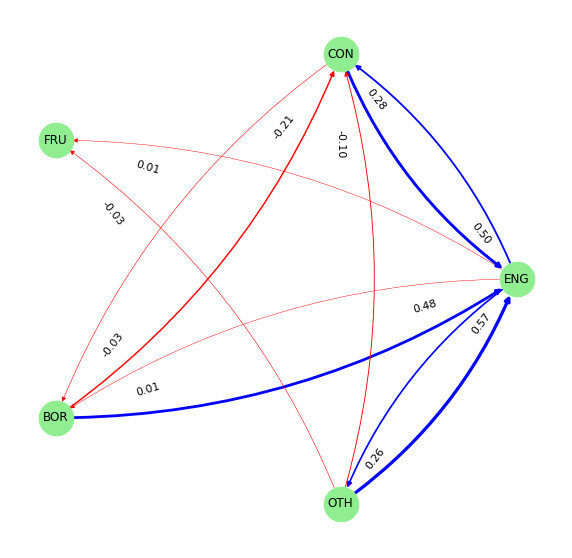

In [ ]:
# it computes the list of students to be included in the analysis 
students_to_include_list = compute_students_to_include( students_amount=30,
                                                        gender_filter=False,
                                                        gender_text="M",
                                                        show_info=True)

# it computes the list of emotions labels to be considered according to the list of students
transitions_list = compute_list_of_emotion_labels(students_to_include=students_to_include_list,
                                                  consider_emotion_duration=False,
                                                  filter_emotion_duration=False,
                                                  emotion_to_filter_text="ENG",
                                                  duration_greater_than=True,
                                                  duration_threshold_method="mean",
                                                  show_info=False)

# based on the list of emotions labels, it computes the L metric matrix and the averaged L matrix
L_metric_results, L_metric_average_results = compute_statistic(seq_list=transitions_list,
                                                               states=emotions_list, 
                                                               L_star=False, 
                                                               use_mean_rates=False)

# compute the p values for each transition according to the L matrix and the average L matrix
p_values_matrix = calculate_p_values(states_list=emotions_list, 
                                     L_metric_average_results=L_metric_average_results, 
                                     level_at_change=L_metric_at_chance_threshold)

# compute the t test adjustment according to the BH post hoc method 
multiple_tests_matrix, multiple_tests_reject_matrix = calculate_multiple_t_test_adjustment(states_list=emotions_list, 
                                                                                           matrix_p_values=p_values_matrix)

# compute the emotion transitions count
emotion_counts = get_emotion_transitions_counts(list_seq=transitions_list, 
                                                states=emotions_list)

# print the results according to the predefined metrics
print_vals(L_metric_results, 
           p_values_matrix, 
           multiple_tests_matrix, 
           multiple_tests_reject_matrix, 
           emotion_counts, 
           emotions_list,
           print_types=table_metrics_to_print)

# create the affect dynamics graph according to the calculated results
# it prints only significant transitions according to the L_metric_at_chance_threshold and the multiple_tests_reject_matrix
print_affect_dynamics_graph(L_metric_results, multiple_tests_reject_matrix, emotions_list, threshold=L_metric_at_chance_threshold)




Execution 5: Gender-based affect dynamics models building
---
This part of the code executes the previous defined functions and set the paremeters to build the gender-based affect dynamics model, considering the data from the students according their gender: Male or Female.


Gender-based affect dynamics model - Male students
Number of students:  14
Students ids:  [3, 4, 5, 7, 8, 10, 12, 14, 15, 16, 25, 28, 29, 30]
Prev\Next;ENG;CON;FRU;BOR;OTH
ENG;na (na)  [1175]  {na} ;0.2809 (0.0098)  [53]  {1.0} ;-0.0110 (0.0001)  [6]  {1.0} ;0.0036 (0.0284)  [9]  {1.0} ;0.3201 (0.0022)  [61]  {1.0} 
CON;0.5254 (0.0017)  [48]  {1.0} ;na (na)  [484]  {na} ;0.0514 (0.7696)  [9]  {0.0} ;-0.0438 (0.0036)  [1]  {1.0} ;-0.0767 (0.1811)  [11]  {0.0} 
FRU;-0.1826 (0.2683)  [5]  {0.0} ;0.1538 (0.5662)  [5]  {0.0} ;na (na)  [28]  {na} ;0.0117 (0.4883)  [1]  {0.0} ;0.1821 (0.4534)  [7]  {0.0} 
BOR;0.4653 (0.0691)  [11]  {0.0} ;-0.1848 (0.0023)  [1]  {1.0} ;0.0673 (0.9645)  [1]  {0.0} ;na (na)  [76]  {na} ;-0.0811 (0.3774)  [4]  {0.0} 
OTH;0.6064 (0.0000)  [62]  {1.0} ;-0.1465 (0.0033)  [11]  {1.0} ;-0.0239 (0.0030)  [2]  {1.0} ;0.0518 (0.7795)  [7]  {0.0} ;na (na)  [419]  {na} 


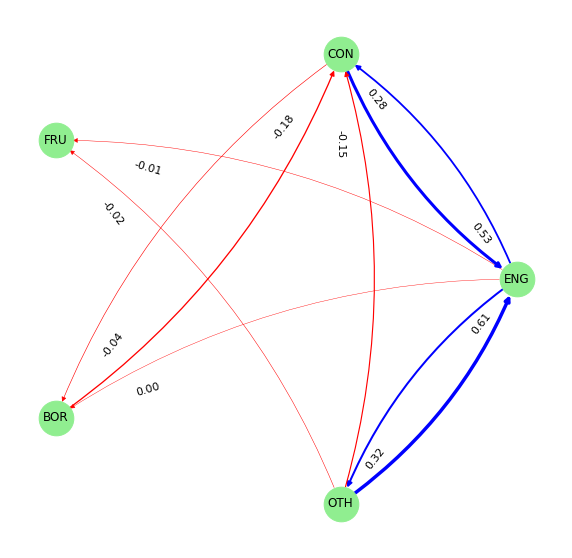

In [ ]:
print("Gender-based affect dynamics model - Male students")

# it computes the list of students to be included in the analysis 
# in this case, we have filtered only for male students
students_to_include_list = compute_students_to_include( students_amount=30,
                                                        gender_filter=True,
                                                        gender_text="M",
                                                        show_info=True)

# it computes the list of emotions labels to be considered according to the list of students
transitions_list = compute_list_of_emotion_labels(students_to_include=students_to_include_list,
                                                  consider_emotion_duration=False,
                                                  filter_emotion_duration=False,
                                                  emotion_to_filter_text="ENG",
                                                  duration_greater_than=True,
                                                  duration_threshold_method="mean",
                                                  show_info=False)

# based on the list of emotions labels, it computes the L metric matrix and the averaged L matrix
L_metric_results, L_metric_average_results = compute_statistic(seq_list=transitions_list,
                                                               states=emotions_list, 
                                                               L_star=False, 
                                                               use_mean_rates=False)

# compute the p values for each transition according to the L matrix and the average L matrix
p_values_matrix = calculate_p_values(states_list=emotions_list, 
                                     L_metric_average_results=L_metric_average_results, 
                                     level_at_change=L_metric_at_chance_threshold)

# compute the t test adjustment according to the BH post hoc method 
multiple_tests_matrix, multiple_tests_reject_matrix = calculate_multiple_t_test_adjustment(states_list=emotions_list, 
                                                                                           matrix_p_values=p_values_matrix)

# compute the emotion transitions count
emotion_counts = get_emotion_transitions_counts(list_seq=transitions_list, 
                                                states=emotions_list)

# print the results according to the predefined metrics
print_vals(L_metric_results, 
           p_values_matrix, 
           multiple_tests_matrix, 
           multiple_tests_reject_matrix, 
           emotion_counts, 
           emotions_list,
           print_types=table_metrics_to_print)

# create the affect dynamics graph according to the calculated results
# it prints only significant transitions according to the L_metric_at_chance_threshold and the multiple_tests_reject_matrix
print_affect_dynamics_graph(L_metric_results, multiple_tests_reject_matrix, emotions_list, threshold=L_metric_at_chance_threshold)



Gender-based affect dynamics model - Female students
Number of students:  16
Students ids:  [1, 2, 6, 9, 11, 13, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27]
Prev\Next;ENG;CON;FRU;BOR;OTH
ENG;na (na)  [1392]  {na} ;0.2719 (0.0015)  [70]  {1.0} ;0.0224 (0.0144)  [10]  {1.0} ;0.0228 (0.0978)  [16]  {0.0} ;0.2168 (0.0018)  [59]  {1.0} 
CON;0.4782 (0.0026)  [68]  {1.0} ;na (na)  [526]  {na} ;0.0232 (0.2418)  [4]  {0.0} ;-0.0122 (0.0232)  [6]  {1.0} ;-0.0074 (0.2909)  [24]  {0.0} 
FRU;0.2986 (0.2708)  [7]  {0.0} ;0.1986 (0.4663)  [6]  {0.0} ;na (na)  [116]  {na} ;-0.0937 (0.0002)  [0]  {1.0} ;-0.2461 (0.0317)  [2]  {0.0} 
BOR;0.4877 (0.0063)  [20]  {1.0} ;-0.2238 (0.0011)  [3]  {1.0} ;0.0336 (0.6867)  [1]  {0.0} ;na (na)  [146]  {na} ;-0.0736 (0.0660)  [7]  {0.0} 
OTH;0.5349 (0.0000)  [57]  {1.0} ;-0.0624 (0.1078)  [21]  {0.0} ;-0.0423 (0.0000)  [0]  {1.0} ;0.0153 (0.0798)  [10]  {0.0} ;na (na)  [420]  {na} 


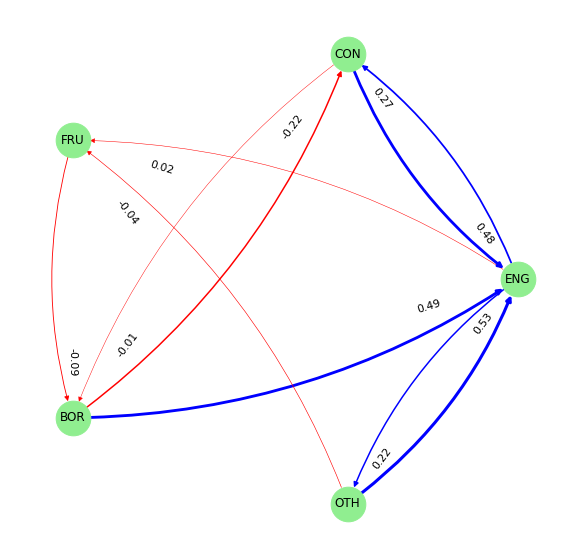

In [ ]:
print("Gender-based affect dynamics model - Female students")

# it computes the list of students to be included in the analysis 
# in this case, we have filtered only for female students
students_to_include_list = compute_students_to_include( students_amount=30,
                                                        gender_filter=True,
                                                        gender_text="F",
                                                        show_info=True)

# it computes the list of emotions labels to be considered according to the list of students
transitions_list = compute_list_of_emotion_labels(students_to_include=students_to_include_list,
                                                  consider_emotion_duration=False,
                                                  filter_emotion_duration=False,
                                                  emotion_to_filter_text="ENG",
                                                  duration_greater_than=True,
                                                  duration_threshold_method="mean",
                                                  show_info=False)

# based on the list of emotions labels, it computes the L metric matrix and the averaged L matrix
L_metric_results, L_metric_average_results = compute_statistic(seq_list=transitions_list,
                                                               states=emotions_list, 
                                                               L_star=False, 
                                                               use_mean_rates=False)

# compute the p values for each transition according to the L matrix and the average L matrix
p_values_matrix = calculate_p_values(states_list=emotions_list, 
                                     L_metric_average_results=L_metric_average_results, 
                                     level_at_change=L_metric_at_chance_threshold)

# compute the t test adjustment according to the BH post hoc method 
multiple_tests_matrix, multiple_tests_reject_matrix = calculate_multiple_t_test_adjustment(states_list=emotions_list, 
                                                                                           matrix_p_values=p_values_matrix)

# compute the emotion transitions count
emotion_counts = get_emotion_transitions_counts(list_seq=transitions_list, 
                                                states=emotions_list)

# print the results according to the predefined metrics
print_vals(L_metric_results, 
           p_values_matrix, 
           multiple_tests_matrix, 
           multiple_tests_reject_matrix, 
           emotion_counts, 
           emotions_list,
           print_types=table_metrics_to_print)

# create the affect dynamics graph according to the calculated results
# it prints only significant transitions according to the L_metric_at_chance_threshold and the multiple_tests_reject_matrix
print_affect_dynamics_graph(L_metric_results, multiple_tests_reject_matrix, emotions_list, threshold=L_metric_at_chance_threshold)



Execution 6: Permanence time-based affect dynamics models building
---
This part of the code executes the previous defined functions and set the paremeters to build the permanence time-based affect dynamics model, considering the data from all the students.

Compute the permanence time-based affect dynamics when the permanence is LESS THAN the MEDIAN in each emotion
Number of students:  30
Students ids:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Calculating emotion:  ENG
Prev\Next;ENG;CON;FRU;BOR;OTH
ENG;na (na)  [0]  {na} ;0.3445 (0.0006)  [74]  {1.0} ;0.0669 (0.9324)  [9]  {0.0} ;-0.0193 (0.0000)  [8]  {1.0} ;0.1631 (0.1599)  [59]  {0.0} 
Calculating emotion:  CON
Prev\Next;ENG;CON;FRU;BOR;OTH
CON;0.5601 (0.0000)  [63]  {1.0} ;na (na)  [0]  {na} ;0.0148 (0.2486)  [4]  {0.0} ;-0.0057 (0.1394)  [4]  {0.0} ;-0.0948 (0.0152)  [18]  {1.0} 
Calculating emotion:  FRU
Prev\Next;ENG;CON;FRU;BOR;OTH
FRU;0.1118 (0.7821)  [9]  {0.0} ;0.1268 (0.6587)  [6]  {0.0} ;na (na)  [0]  {na} ;0.0040 (0.4653)  [1]  {0.0} ;-0.0896 (0.2396)  [5]  {0.0} 
Calculating emotion:  BOR
Prev\Next;ENG;CON;FRU;BOR;OTH
BOR;0.5723 (0.0037)  [19]  {1.0} ;-0.1773 (0.0069)  [2]  {1.0} ;0.0120 (0.4044)  [1]  {

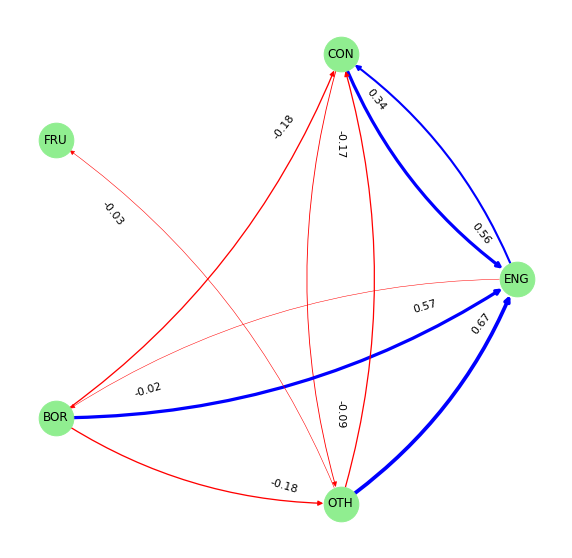

In [ ]:
print("Compute the permanence time-based affect dynamics when the permanence is LESS THAN the MEDIAN in each emotion")

# this code uses the data from all the students, but it filters the labels according to the permanence time in each emotion

# this variable defines whether the emotions considered will be less or greater than a certain threshold
general_duration_greater_than = False
# this variable defines whitch statistical method will be used to calculate the threshold
general_duration_threshold_method = "median" 

# it computes the list of students to be included in the analysis
students_to_include_list = compute_students_to_include( students_amount=30,
                                                        gender_filter=False,
                                                        gender_text="M",
                                                        show_info=True)

# it computes the list of emotions labels to be considered according to the list of students
# at this moment, all the transitions are considered to be used as bases for the count calculation
transitions_list = compute_list_of_emotion_labels(students_to_include=students_to_include_list,
                                                                consider_emotion_duration=False,
                                                                filter_emotion_duration=False,
                                                                emotion_to_filter_text="ENG",
                                                                duration_greater_than=general_duration_greater_than,
                                                                duration_threshold_method=general_duration_threshold_method,
                                                                show_info=False)

# stores the L metric results for each emotion
general_L_metric_results = []
# stores the multiple teste rejection result for each transition and for each emotion
general_multiple_tests_reject_matrix = []

# because we have considered only the transitions according the permanence time, we have used the emotion only as source
# for example, when computing the emotion engagement, we have considered only the transitions in which engagement is the source emotion
# this decision was made to avoid adding a bias on the transitions count, reflecting on the wrong calculation of the L metric
# therefore, we compute each emotion separately (according their own permanence time) to after consider it in the model building
for index, emotion in enumerate(emotions_list):
  print("Calculating emotion: ", emotion)

  # it computes the list of emotions labels to be considered according to the list of students
  # at this moment we filter the transitions according their permanence time
  transitions_timed_list = compute_list_of_emotion_labels(students_to_include=students_to_include_list,
                                                                  consider_emotion_duration=True,
                                                                  filter_emotion_duration=True,
                                                                  emotion_to_filter_text=emotion,
                                                                  duration_greater_than=general_duration_greater_than,
                                                                  duration_threshold_method=general_duration_threshold_method,
                                                                  show_info=False)

  # based on the list of emotions labels, it computes the L metric matrix and the averaged L matrix
  L_metric_results, L_metric_average_results = compute_statistic(seq_list=transitions_list, 
                                                                seq_timed_list=transitions_timed_list,
                                                                states=emotions_list, 
                                                                L_star=False, 
                                                                use_mean_rates=False,
                                                                consider_timed_list=True)

  # compute the p values for each transition according to the L matrix and the average L matrix
  p_values_matrix = calculate_p_values(states_list=emotions_list, 
                                      L_metric_average_results=L_metric_average_results, 
                                      level_at_change=L_metric_at_chance_threshold)

  # compute the t test adjustment according to the BH post hoc method 
  multiple_tests_matrix, multiple_tests_reject_matrix = calculate_multiple_t_test_adjustment(states_list=emotions_list, 
                                                                                            matrix_p_values=p_values_matrix)

  # compute the emotion transitions count
  emotion_counts = get_emotion_transitions_counts(list_seq=transitions_timed_list, 
                                                  states=emotions_list)

  # print the results according to the predefined metrics
  print_vals(L_metric_results, 
            p_values_matrix, 
            multiple_tests_matrix, 
            multiple_tests_reject_matrix, 
            emotion_counts, 
            emotions_list,
            print_types=table_metrics_to_print,
            lines_to_include=[index])
  
  if index == 0:
    general_L_metric_results = L_metric_results
    general_multiple_tests_reject_matrix = multiple_tests_reject_matrix
  else:
    general_L_metric_results[index] = L_metric_results[index]
    general_multiple_tests_reject_matrix[index] = multiple_tests_reject_matrix[index]


# create the affect dynamics graph according to the calculated results
# it prints only significant transitions according to the L_metric_at_chance_threshold and the multiple_tests_reject_matrix
print_affect_dynamics_graph(general_L_metric_results, general_multiple_tests_reject_matrix, emotions_list, threshold=L_metric_at_chance_threshold)

Compute the permanence time-based affect dynamics when the permanence is LESS THAN the MEDIAN in each emotion
Number of students:  30
Students ids:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Calculating emotion:  ENG
Prev\Next;ENG;CON;FRU;BOR;OTH
ENG;na (na)  [0]  {na} ;0.2498 (0.0167)  [60]  {1.0} ;0.0191 (0.0523)  [8]  {0.0} ;0.0407 (0.3882)  [16]  {0.0} ;0.2375 (0.0073)  [65]  {1.0} 
Calculating emotion:  CON
Prev\Next;ENG;CON;FRU;BOR;OTH
CON;0.5177 (0.0001)  [59]  {1.0} ;na (na)  [0]  {na} ;0.0444 (0.5736)  [9]  {0.0} ;-0.0180 (0.0548)  [3]  {0.0} ;-0.0620 (0.0954)  [17]  {0.0} 
Calculating emotion:  FRU
Prev\Next;ENG;CON;FRU;BOR;OTH
FRU;-0.0875 (0.4291)  [6]  {0.0} ;0.2471 (0.2577)  [8]  {0.0} ;na (na)  [0]  {na} ;-0.0369 (0.0701)  [1]  {0.0} ;-0.0094 (0.6511)  [4]  {0.0} 
Calculating emotion:  BOR
Prev\Next;ENG;CON;FRU;BOR;OTH
BOR;0.4390 (0.0266)  [18]  {0.0} ;-0.2206 (0.0020)  [2]  {1.0} ;0.0184 (0.4362)  [1] 

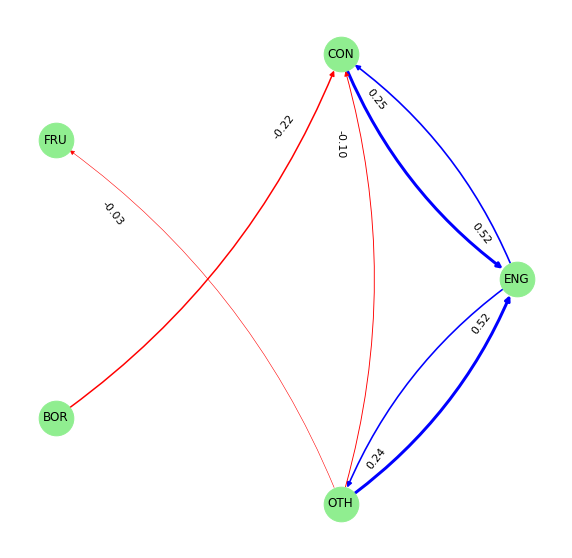

In [ ]:
print("Compute the permanence time-based affect dynamics when the permanence is LESS THAN the MEDIAN in each emotion")

# this code uses the data from all the students, but it filters the labels according to the permanence time in each emotion

# this variable defines whether the emotions considered will be less or greater than a certain threshold
general_duration_greater_than = True
# this variable defines whitch statistical method will be used to calculate the threshold
general_duration_threshold_method = "median" 

# it computes the list of students to be included in the analysis
students_to_include_list = compute_students_to_include( students_amount=30,
                                                        gender_filter=False,
                                                        gender_text="M",
                                                        show_info=True)

# it computes the list of emotions labels to be considered according to the list of students
# at this moment, all the transitions are considered to be used as bases for the count calculation
transitions_list = compute_list_of_emotion_labels(students_to_include=students_to_include_list,
                                                                consider_emotion_duration=False,
                                                                filter_emotion_duration=False,
                                                                emotion_to_filter_text="ENG",
                                                                duration_greater_than=general_duration_greater_than,
                                                                duration_threshold_method=general_duration_threshold_method,
                                                                show_info=False)

# stores the L metric results for each emotion
general_L_metric_results = []
# stores the multiple teste rejection result for each transition and for each emotion
general_multiple_tests_reject_matrix = []

# because we have considered only the transitions according the permanence time, we have used the emotion only as source
# for example, when computing the emotion engagement, we have considered only the transitions in which engagement is the source emotion
# this decision was made to avoid adding a bias on the transitions count, reflecting on the wrong calculation of the L metric
# therefore, we compute each emotion separately (according their own permanence time) to after consider it in the model building
for index, emotion in enumerate(emotions_list):
  print("Calculating emotion: ", emotion)

  # it computes the list of emotions labels to be considered according to the list of students
  # at this moment we filter the transitions according their permanence time
  transitions_timed_list = compute_list_of_emotion_labels(students_to_include=students_to_include_list,
                                                                  consider_emotion_duration=True,
                                                                  filter_emotion_duration=True,
                                                                  emotion_to_filter_text=emotion,
                                                                  duration_greater_than=general_duration_greater_than,
                                                                  duration_threshold_method=general_duration_threshold_method,
                                                                  show_info=False)

  # based on the list of emotions labels, it computes the L metric matrix and the averaged L matrix
  L_metric_results, L_metric_average_results = compute_statistic(seq_list=transitions_list, 
                                                                seq_timed_list=transitions_timed_list,
                                                                states=emotions_list, 
                                                                L_star=False, 
                                                                use_mean_rates=False,
                                                                consider_timed_list=True)

  # compute the p values for each transition according to the L matrix and the average L matrix
  p_values_matrix = calculate_p_values(states_list=emotions_list, 
                                      L_metric_average_results=L_metric_average_results, 
                                      level_at_change=L_metric_at_chance_threshold)

  # compute the t test adjustment according to the BH post hoc method 
  multiple_tests_matrix, multiple_tests_reject_matrix = calculate_multiple_t_test_adjustment(states_list=emotions_list, 
                                                                                            matrix_p_values=p_values_matrix)

  # compute the emotion transitions count
  emotion_counts = get_emotion_transitions_counts(list_seq=transitions_timed_list, 
                                                  states=emotions_list)

  # print the results according to the predefined metrics
  print_vals(L_metric_results, 
            p_values_matrix, 
            multiple_tests_matrix, 
            multiple_tests_reject_matrix, 
            emotion_counts, 
            emotions_list,
            print_types=table_metrics_to_print,
            lines_to_include=[index])
  
  if index == 0:
    general_L_metric_results = L_metric_results
    general_multiple_tests_reject_matrix = multiple_tests_reject_matrix
  else:
    general_L_metric_results[index] = L_metric_results[index]
    general_multiple_tests_reject_matrix[index] = multiple_tests_reject_matrix[index]


# create the affect dynamics graph according to the calculated results
# it prints only significant transitions according to the L_metric_at_chance_threshold and the multiple_tests_reject_matrix
print_affect_dynamics_graph(general_L_metric_results, general_multiple_tests_reject_matrix, emotions_list, threshold=L_metric_at_chance_threshold)